In [2]:
import time
import numpy as np
import pandas as pd
from dateutil.parser import parse
from datetime import date, timedelta
from sklearn.preprocessing import LabelEncoder
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor, wait
import functools  

import arrow
import math
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
feats = pd.read_feather(r'result/agg_ts_feas_p2017-03-22_e2017-04-22_s2016-01-01').drop('index', axis=1, errors='ignore')
# test_feat = pd.read_feather(r'result/period_e2017-04-23_n39').drop('index', axis=1, errors='ignore')

In [3]:
train_feats = pd.read_feather(r'result/agg_ts_feas_p2017-01-30_e2017-03-12_s2016-01-01').drop('index', axis=1, errors='ignore')
val_feats  = pd.read_feather(r'result/period_e2017-03-12_n42').drop('index', axis=1, errors='ignore')

In [2]:
train_feats = pd.read_feather(r'result/agg_ts_feas_p2017-03-22_e2017-04-22_s2016-01-01').drop('index', axis=1, errors='ignore')
# test_feats  = pd.read_feather(r'result/period_e2017-04-23_n39').drop('index', axis=1, errors='ignore')

In [13]:
# to_keep = ['id','store_id','visit_date','end_date','air_area_name','visitors','month',
#           'air_area_name0','genre_dow_mean28',
#              'genre_dow_mean56', 'store_dow_count1000',
#              'store_dow_count14',
#              'store_dow_count28',
#              'store_dow_count56',]
# feats = feats[to_keep]

In [4]:
# list(feats.columns)

In [5]:
# ratio = 0.9
# val_size = len(feats) - int(len(feats) * ratio)
# train_feat = feats.iloc[val_size:]
# val_feat = feats.iloc[:val_size]

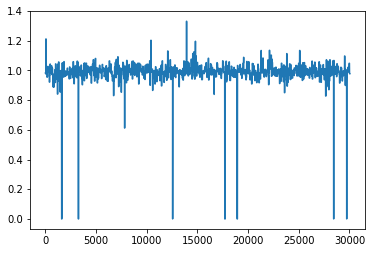

In [5]:
val_feats['store_mean_14_28_rate'].plot()

In [6]:
# list(test_feat.columns)

In [6]:
predictors = [f for f in train_feats.columns if f not in (['id','store_id','visit_date','end_date','air_area_name','visitors','month'])]

In [7]:
import lightgbm as lgb

params = {
    'learning_rate': 0.02,
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'sub_feature': 0.7,
    'num_leaves': 60,
    'min_data': 100,
    'min_hessian': 1,

#     'verbose': -1,
}


In [5]:
lgb_train = lgb.Dataset(train_feats[predictors], train_feats['visitors'])
# lgb_test = lgb.Dataset(test_feats[predictors], test_feats['visitors'])

In [8]:
lgb_train = lgb.Dataset(train_feats[predictors], train_feats['visitors'])
lgb_val = lgb.Dataset(val_feats[predictors], val_feats['visitors'])
# lgb_test = lgb.Dataset(test_feat[predictors], test_feat['visitors'])

In [13]:
# evals_result = {}
# gbm = lgb.train(params,
#                 lgb_train,
#                 2300,
#                 valid_sets=(lgb_train, lgb_val), # , lgb_val
#                 evals_result=evals_result,)

In [26]:
# params = {
#     'learning_rate': 0.1,
#     'boosting_type': 'gbdt',
#     'objective': 'regression',
#     'metric': 'rmse',
#     'sub_feature': 0.7,
#     'num_leaves': 60,
#     'min_data': 100,
#     'min_hessian': 1,

# #     'verbose': -1,
# }
# gbm = lgb.train(params,
#                 lgb_train,
#                 num_boost_round=10,
#                 init_model='result/gbm.txt',
#                 valid_sets=(lgb_train, lgb_val))

In [18]:
# gbm.save_model('result/gbm.txt')

Plot metrics during training...


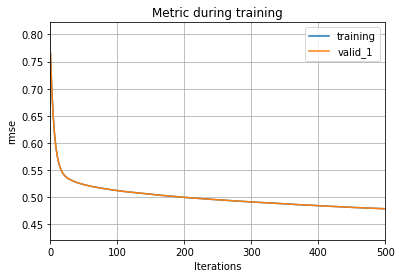

In [20]:
print('Plot metrics during training...')
ax = lgb.plot_metric(evals_result)
plt.show()

In [33]:
gbm = lgb.Booster(model_file='result/gbm.txt')

In [24]:
pred = gbm.predict(val_feat[predictors])

In [1]:
plt.plot(pred)
plt.plot(val_feat[predictors].visitors)

NameError: name 'plt' is not defined

In [70]:
def rmsle(x, y):
    return math.sqrt(((x-y)**2).mean())

In [72]:
rmsle(pred, train_feat.iloc[:100].visitors.values)

0.5673981880755363

In [10]:
gld_feat = pd.read_feather(r'result/org_test').drop('index', axis=1, errors='ignore')

In [17]:
set(test_feat.columns) - set(gld_feat.columns)

set()

In [27]:
def diff(df1, df2, iloc):
    ser1 = df1.iloc[iloc]
    ser2 = df2.iloc[iloc]
    for val1, val2 in zip(ser1, ser2):
        if val1 != val2:
            print(val1, val2)

diff(gld_feat, test_feat, 2)

In [32]:
i

11179

In [6]:
arrow.get('2017-04-22') - arrow.get('2017-03-12')

datetime.timedelta(41)

In [10]:
arrow.get('2017-03-12') - arrow.get('2017-01-30')

datetime.timedelta(41)

In [22]:
submission = pd.read_csv('data/sample_submission.csv')

submission['visit_date'] = submission['id'].str[-10:]
submission['store_id'] = submission['id'].str[:-11]

subm = pd.DataFrame({'id':test_feat.store_id + '_' + test_feat.visit_date,'visitors':np.expm1(pred)})
subm = submission[['id']].merge(subm,on='id',how='left').fillna(0)
subm.to_csv(r'result/sub.csv', index=False)

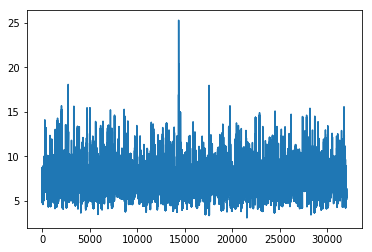

In [24]:
subm["visitors"].plot()

In [11]:
import utils

# test_feat = pd.read_feather(r'result/period_e2017-04-23_n39').drop('index', axis=1, errors='ignore')
test_feat = gld_feat.copy()
csv_fn=f'sub7.csv'
pred_test=gbm.predict(test_feat[predictors])
pred_test = np.expm1(pred_test)
test_feat['visitors']=pred_test
test_feat['air_store_id'] = test_feat.store_id
sub = utils.trn2test(test_feat.reset_index()[['air_store_id', 'visit_date', 'visitors']])
sub.to_csv(csv_fn, index=False)

In [16]:
test_feat.id.head()

0    air_00a91d42b08b08d9_2017-04-23
1    air_00a91d42b08b08d9_2017-04-24
2    air_00a91d42b08b08d9_2017-04-25
3    air_00a91d42b08b08d9_2017-04-26
4    air_00a91d42b08b08d9_2017-04-27
Name: id, dtype: object

In [14]:
sub.head()

,id,visitors
0,air_00a91d42b08b08d9_2017-04-23,4.151510
1,air_00a91d42b08b08d9_2017-04-24,24.442456
2,air_00a91d42b08b08d9_2017-04-25,27.218779
3,air_00a91d42b08b08d9_2017-04-26,27.524710
4,air_00a91d42b08b08d9_2017-04-27,31.601258


In [20]:
sub.head()

,id,visitors
0,air_00a91d42b08b08d9_2017-04-23,3.130138
1,air_00a91d42b08b08d9_2017-04-24,22.461168
2,air_00a91d42b08b08d9_2017-04-25,24.732350
3,air_00a91d42b08b08d9_2017-04-26,25.403013
4,air_00a91d42b08b08d9_2017-04-27,24.755698


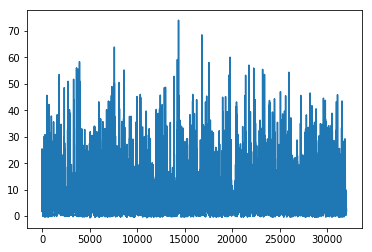

In [22]:
sub.visitors.plot()

In [2]:
data_path = r'/Users/kevindu/Documents/workspace/ai/data/RRVF/' # r'E:\workspace\ai\ml_utils\proj\RRVF\data\\'

def get_data(data_path):
    air_reserve = pd.read_csv(data_path + 'air_reserve.csv').rename(columns={'air_store_id':'store_id'})
    hpg_reserve = pd.read_csv(data_path + 'hpg_reserve.csv').rename(columns={'hpg_store_id':'store_id'})
    air_store = pd.read_csv(data_path + 'air_store_info.csv').rename(columns={'air_store_id':'store_id'})
    hpg_store = pd.read_csv(data_path + 'hpg_store_info.csv').rename(columns={'hpg_store_id':'store_id'})
    air_visit = pd.read_csv(data_path + 'air_visit_data.csv').rename(columns={'air_store_id':'store_id'})
    store_id_map = pd.read_csv(data_path + 'store_id_relation.csv').set_index('hpg_store_id',drop=False)
    date_info = pd.read_csv(data_path + 'date_info.csv').rename(columns={'calendar_date': 'visit_date'}).drop('day_of_week',axis=1)
    submission = pd.read_csv(data_path + 'sample_submission.csv')

    submission['visit_date'] = submission['id'].str[-10:]
    submission['store_id'] = submission['id'].str[:-11]
    air_reserve['visit_date'] = air_reserve['visit_datetime'].str[:10]
    air_reserve['reserve_date'] = air_reserve['reserve_datetime'].str[:10]
    air_reserve['dow'] = pd.to_datetime(air_reserve['visit_date']).dt.dayofweek
    hpg_reserve['visit_date'] = hpg_reserve['visit_datetime'].str[:10]
    hpg_reserve['reserve_date'] = hpg_reserve['reserve_datetime'].str[:10]
    hpg_reserve['dow'] = pd.to_datetime(hpg_reserve['visit_date']).dt.dayofweek
    air_visit['id'] = air_visit['store_id'] + '_' + air_visit['visit_date']
    hpg_reserve['store_id'] = hpg_reserve['store_id'].map(store_id_map['air_store_id']).fillna(hpg_reserve['store_id'])
    hpg_store['store_id'] = hpg_store['store_id'].map(store_id_map['air_store_id']).fillna(hpg_store['store_id'])
    # consider genre in hpg as air genre
    hpg_store.rename(columns={'hpg_genre_name':'air_genre_name','hpg_area_name':'air_area_name'},inplace=True)
    data = pd.concat([air_visit, submission]).copy()
    data['dow'] = pd.to_datetime(data['visit_date']).dt.dayofweek

    # take weekend 5 6 1, as a kind of holiday
    # dow is a very important feature
    date_info['holiday_flg2'] = pd.to_datetime(date_info['visit_date']).dt.dayofweek
    date_info['holiday_flg2'] = ((date_info['holiday_flg2']>4) | (date_info['holiday_flg']==1)).astype(int)

    # Split on area name, should also consider the number of competitors within a distance
    air_store['air_area_name0'] = air_store['air_area_name'].apply(lambda x: x.split(' ')[0])
    lbl = LabelEncoder()
    air_store['air_genre_name'] = lbl.fit_transform(air_store['air_genre_name'])
    air_store['air_area_name0'] = lbl.fit_transform(air_store['air_area_name0'])

    # per the chanllege request
    data['visitors'] = np.log1p(data['visitors'])
    data = data.merge(air_store,on='store_id',how='left')
    data = data.merge(date_info[['visit_date','holiday_flg','holiday_flg2']], on=['visit_date'],how='left')
    result = {
        "data": data,
        "hpg_store": hpg_store,
        "air_store": air_store,
        "air_reserve": air_reserve,
        "hpg_reserve": hpg_reserve,
    }
    return result

In [6]:
def concat(L):
    result = None
    for l in L:
        if result is None:
            result = l
        else:
            try:
                result[l.columns.tolist()] = l
            except:
                print(l.head())
    return result

def left_merge(data1,data2,on):
    if type(on) != list:
        on = [on]
    if (set(on) & set(data2.columns)) != set(on):
        data2_temp = data2.reset_index()
    else:
        data2_temp = data2.copy()
    columns = [f for f in data2.columns if f not in on]
    result = data1.merge(data2_temp,on=on,how='left')
    result = result[columns]
    return result


def diff_of_days(day1, day2):
    days = (parse(day1[:10]) - parse(day2[:10])).days
    return days

def date_add_days(start_date, days):
    end_date = parse(start_date[:10]) + timedelta(days=days)
    end_date = end_date.strftime('%Y-%m-%d')
    return end_date

def get_label(end_date, n_day):
    """ 
    end_date : end of statistic set
    n_day: the span of label set
    """
    label_end_date = date_add_days(end_date, n_day)
    label = data[(data['visit_date'] < label_end_date) & (data['visit_date'] >= end_date)].copy()
    label['end_date'] = end_date
    # diff of pivot date and visit date
    # related to weighting
    label['diff_of_day'] = label['visit_date'].apply(lambda x: diff_of_days(x,end_date))
    label['month'] = label['visit_date'].str[5:7].astype(int)
    label['year'] = label['visit_date'].str[:4].astype(int)
    # before & after holiday trend
    for i in [3,2,1,-1]:
        date_info_temp = date_info.copy()
        date_info_temp['visit_date'] = date_info_temp['visit_date'].apply(lambda x: date_add_days(x,i))
        date_info_temp.rename(columns={'holiday_flg':'ahead_holiday_{}'.format(i),'holiday_flg2':'ahead_holiday2_{}'.format(i)},inplace=True)
        label = label.merge(date_info_temp, on=['visit_date'],how='left')
    label = label.reset_index(drop=True)
    return label

def get_store_visitor_feat(label, key, n_day):
    start_date = date_add_days(key[0],-n_day)
    data_temp = data[(data.visit_date < key[0]) & (data.visit_date > start_date)].copy()
    result = data_temp.groupby(['store_id'], as_index=False)['visitors'].agg({'store_min{}'.format(n_day): 'min',
                                                                             'store_mean{}'.format(n_day): 'mean',
                                                                             'store_median{}'.format(n_day): 'median',
                                                                             'store_max{}'.format(n_day): 'max',
                                                                             'store_count{}'.format(n_day): 'count',
                                                                             'store_std{}'.format(n_day): 'std',
                                                                             'store_skew{}'.format(n_day): 'skew'})
    result = left_merge(label, result, on=['store_id']).fillna(0)
    return result

In [238]:
def make_feats(data_dict, 
                win,
                label_getter, 
                fes=[], 
                high_eng=None):
        pivot_date = win['pivot_date']
        days_in_label = win['days_in_label']
        key = pivot_date, days_in_label # the idx of label set
        label = label_getter(pivot_date, days_in_label)

        result = [label]
        for feature_eng in fes:
            result.append(feature_eng(label, key))
        result.append(label)
        result = concat(result)
        if high_eng:
            result = high_eng(result)
        return result

class TimeseriesDataset():
    def __init__(
            self,
            pivot_date,
            end_date,
            data_dict,
            date_col,
            date_step,
            days_in_label,
            min_num_in_stat_set,
            label_getter, 
            fes=[], 
            high_eng=None
            ):
        self.__pivot_date = pivot_date
        self.__data_dict = data_dict
        self.__date_col = date_col
        self.__end_date = end_date
        self.__date_step = date_step
        self.__days_in_label = days_in_label
        merged_data = data_dict['data']
        windows = []
        max_date = arrow.get(pivot_date)
        min_date = arrow.get(merged_data.visit_date.min())
        delta = (max_date - min_date).days - min_num_in_stat_set
        nwindows_bf_pivot = int((delta ) / date_step )
        nwindows_af_pivot = math.floor((arrow.get(end_date) - arrow.get(pivot_date)).days / date_step)
        
        start_date = min_date.shift(days=min_num_in_stat_set)
        for day_delta in range(nwindows_bf_pivot):
            # >= start & < end
            windows.append(
                {
                    "pivot_date": start_date.format('YYYY-MM-DD'),
                    "days_in_label": days_in_label
                }
            )
            start_date = start_date.shift(days=date_step)
        start_date = max_date.shift(days=date_step)
        ndays_unit_af_pivot = days_in_label  - days_in_label % date_step
        for day_delta in range(nwindows_af_pivot):
            adaptive_len = ndays_unit_af_pivot - ( day_delta * date_step )
            windows.append(
                {
                    "pivot_date": start_date.format('YYYY-MM-DD'),
                    "days_in_label": adaptive_len
                }
            )
            start_date = start_date.shift(days=date_step)
        self.__windows = windows
        print('nwindows_bf_pivot:{}, nwindows_af_pivot {}'
              .format(nwindows_bf_pivot, nwindows_af_pivot))
        print('First window {}'.format(windows[0]))
        print('Last window {}'.format(windows[-1]))
        self.__label_getter = label_getter
        self.__fes= fes
        self.__high_eng = high_eng

        
    def get_trn(self, concurrency=2):
        feats, results = [], []
        step_task = int(len(self.__windows) / 100)
        num_tasks = len(self.__windows)        
        with ThreadPoolExecutor(max_workers=concurrency) as executor:
            feats = executor.map(
                lambda x: make_feats(win=x,
                                    data_dict=self.__data_dict,
                                      label_getter=self.__label_getter,
                                      fes=self.__fes, 
                                      high_eng=self.__high_eng), 
                self.__windows)
        train_feat = pd.concat(feats)
        return train_feat

    def get_test(self, start_date, ndays):
        feats = []
        test_feat = self.make_feats(pivot_date=start_date, ndays=ndays)
        return test_feat

    def generate_trn(self):
        pass

In [3]:
data_dict = get_data(data_path)

In [247]:
fes= [
    lambda label, key: get_store_visitor_feat(label, key, 1000),
    lambda label, key: get_store_visitor_feat(label, key, 56)
]

ts_data = TimeseriesDataset(
    pivot_date='2016-03-12',
    end_date='2016-04-22',
    data_dict=data_dict,
    date_col='visit_date',
    date_step=7,
    days_in_label=39,
    min_num_in_stat_set=37,
    label_getter=get_label, 
    fes=fes, 
    high_eng=None
)


nwindows_bf_pivot:4, nwindows_af_pivot 5
First window {'pivot_date': '2016-02-07', 'days_in_label': 39}
Last window {'pivot_date': '2016-04-16', 'days_in_label': 7}


In [248]:
trn = ts_data.get_trn(4)

In [249]:
trn.head()

,id,store_id,visit_date,visitors,dow,air_genre_name,air_area_name,latitude,longitude,air_area_name0,...,store_count1000,store_std1000,store_skew1000,store_min56,store_mean56,store_median56,store_max56,store_count56,store_std56,store_skew56
0,air_ba937bf13d40fb24_2016-02-08,air_ba937bf13d40fb24,2016-02-08,2.995732,0,4,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,7,...,20.0,0.505541,-0.752183,1.94591,2.978754,3.091042,3.828641,20.0,0.505541,-0.752183
1,air_ba937bf13d40fb24_2016-02-09,air_ba937bf13d40fb24,2016-02-09,2.772589,1,4,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,7,...,20.0,0.505541,-0.752183,1.94591,2.978754,3.091042,3.828641,20.0,0.505541,-0.752183
2,air_ba937bf13d40fb24_2016-02-10,air_ba937bf13d40fb24,2016-02-10,3.496508,2,4,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,7,...,20.0,0.505541,-0.752183,1.94591,2.978754,3.091042,3.828641,20.0,0.505541,-0.752183
3,air_ba937bf13d40fb24_2016-02-11,air_ba937bf13d40fb24,2016-02-11,1.386294,3,4,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,7,...,20.0,0.505541,-0.752183,1.94591,2.978754,3.091042,3.828641,20.0,0.505541,-0.752183
4,air_ba937bf13d40fb24_2016-02-12,air_ba937bf13d40fb24,2016-02-12,3.295837,4,4,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,7,...,20.0,0.505541,-0.752183,1.94591,2.978754,3.091042,3.828641,20.0,0.505541,-0.752183


In [26]:

data = data_dict['data']
n_day = 39
data_temp = data[(data.visit_date < '2016-04-12') & (data.visit_date > '2016-03-12')].copy()
result_temp = data_temp.groupby(['store_id', 'dow'],as_index=False)['visitors'].agg({'store_dow_mean{}'.format(n_day): 'mean',
                                                                 'store_dow_median{}'.format(n_day): 'median',
                                                                 'store_dow_sum{}'.format(n_day): 'max',
                                                                 'store_dow_count{}'.format(n_day): 'count'})
result = pd.DataFrame()
# label = pd.DataFrame()

# for i in range(7):
#     result_sub = result_temp[result_temp['dow']==i].copy()
#     result_sub = result_sub.set_index('store_id')
#     result_sub = result_sub.add_prefix(str(i))
#     result_sub = left_merge(label, result_sub, on=['store_id']).fillna(0)
#     result = pd.concat([result,result_sub],axis=1)

In [32]:
result_sub = result_temp[result_temp['dow']==0].copy()
result_sub = result_sub.set_index('store_id')
result_sub = result_sub.add_prefix(str(0))

In [35]:
def diff_of_days(day1, day2):
    days = (parse(day1[:10]) - parse(day2[:10])).days
    return days

key = '2016-04-12', 1000
data_temp['visit_date'] = data_temp['visit_date'].apply(lambda x: diff_of_days(key[0],x))
data_temp['visitors2'] = data_temp['visitors']
result = None
for i in [0.9,0.95,0.97,0.98,0.985,0.99,0.999,0.9999]:
    data_temp['weight'] = data_temp['visit_date'].apply(lambda x: i**x)
    data_temp['visitors1'] = data_temp['visitors'] * data_temp['weight']
    data_temp['visitors2'] = data_temp['visitors2'] * data_temp['weight']
    result1 = data_temp.groupby(['store_id', 'dow'], as_index=False)['visitors1'].agg({'store_dow_exp_mean{}_{}'.format(n_day,i): 'sum'})
    result3 = data_temp.groupby(['store_id', 'dow'], as_index=False)['visitors2'].agg({'store_dow_exp_mean2{}_{}'.format(n_day, i): 'sum'})
    result2 = data_temp.groupby(['store_id', 'dow'], as_index=False)['weight'].agg({'store_dow_exp_weight_sum{}_{}'.format(n_day,i): 'sum'})
    result_temp = result1.merge(result2, on=['store_id', 'dow'], how='left')
    result_temp = result_temp.merge(result3, on=['store_id', 'dow'], how='left')
    result_temp['store_dow_exp_mean{}_{}'.format(n_day,i)] = result_temp['store_dow_exp_mean{}_{}'.format(n_day,i)]/result_temp['store_dow_exp_weight_sum{}_{}'.format(n_day,i)]
    result_temp['store_dow_exp_mean2{}_{}'.format(n_day, i)] = result_temp[ 'store_dow_exp_mean2{}_{}'.format(n_day, i)]/result_temp['store_dow_exp_weight_sum{}_{}'.format(n_day, i)]
    if result is None:
        result = result_temp
    else:
        result = result.merge(result_temp,on=['store_id','dow'],how='left')

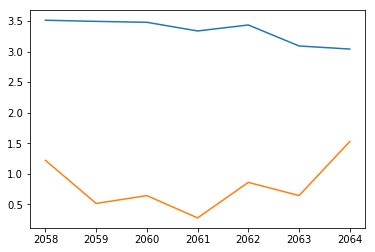

In [43]:
import matplotlib.pyplot as plt
%matplotlib inline
a_store = result[result.store_id == 'air_fe58c074ec1445ea']
plt.plot(a_store["store_dow_exp_mean39_0.97"])
plt.plot(a_store["store_dow_exp_mean239_0.97"])


In [48]:
def a(**params):
    print(params)
    print(b)

In [52]:
a = """
class StoreVisitor(luigi.Task):
    end_date = luigi.Parameter() # static end_date
    ndays = luigi.Parameter() # number of days in labelling set
    stat_ndays = luigi.Parameter()

    def output(self):
        return luigi.LocalTarget(
            '{}store_visitor_{}_{}'.format(RESULT, self.end_date, self.ndays))

    def requires(self):
        return [Dataset(), LabelSet(self.end_date, self.ndays)]

    def run(self):
        data_dict = pkl.load(open(self.input()[0].path, 'rb'))
        label = pd.read_feather(self.input()[1].path)
        key = self.end_date, self.ndays
        feas = get_store_visitor_feat(label, key, self.stat_ndays, data_dict)
        feas.to_feather(self.output().path)
"""

In [53]:
eval(a)

SyntaxError: invalid syntax (<string>, line 2)

In [81]:
class Abc:
    def __init__(self):
        class_name = str(self.__class__).split('.')[-1][:-2]
        print(class_name)

In [83]:
def abc():
    pass

In [84]:
a = eval('abc')

In [86]:
a= "HelloWorld"

In [89]:
import re

In [94]:
re.split('[A-Z]', a)

['', 'ello', 'orld']

In [117]:
content = """result.append(get_store_visitor_feat(label, key, 1000))        # store features
    result.append(get_store_visitor_feat(label, key, 56))          # store features
    result.append(get_store_visitor_feat(label, key, 28))          # store features
    result.append(get_store_visitor_feat(label, key, 14))          # store features
    result.append(get_store_exp_visitor_feat(label, key, 1000))    # store exp features
    result.append(get_store_week_feat(label, key, 1000))           # store dow features
    result.append(get_store_week_feat(label, key, 56))             # store dow features
    result.append(get_store_week_feat(label, key, 28))             # store dow features
    result.append(get_store_week_feat(label, key, 14))             # store dow features
    result.append(get_store_week_diff_feat(label, key, 58))       # store dow diff features
    result.append(get_store_week_diff_feat(label, key, 1000))      # store dow diff features
    result.append(get_store_all_week_feat(label, key, 1000))       # store all week feat
    result.append(get_store_week_exp_feat(label, key, 1000))       # store dow exp feat
    result.append(get_store_holiday_feat(label, key, 1000))        # store holiday feat
    result.append(get_genre_visitor_feat(label, key, 1000))         # genre feature
    result.append(get_genre_visitor_feat(label, key, 56))           # genre feature
    result.append(get_genre_visitor_feat(label, key, 28))           # genre feature
    result.append(get_genre_exp_visitor_feat(label, key, 1000))     # genre feature
    result.append(get_genre_week_feat(label, key, 1000))            # genre dow feature
    result.append(get_genre_week_feat(label, key, 56))              # genre dow feature
    result.append(get_genre_week_feat(label, key, 28))              # genre dow feature
    result.append(get_genre_week_exp_feat(label, key, 1000))        # genre dow exp feature
    result.append(get_reserve_feat(label,key))                      # air_reserve
    result.append(get_first_last_time_feat(label,key,1000))"""

In [139]:
codes = []
cls_re = re.compile('get_([a-z_]*)_feat')
for line in content.splitlines():
    class_name = cls_re.findall(line)[0].title().replace('_', '')
    prd = re.findall('([0-9]*)\)', line)[0]
    if not prd: prd = -1
    print("{}(self.end_date, self.ndays, {}),".format(class_name, prd, ))

StoreVisitor(self.end_date, self.ndays, 1000),
StoreVisitor(self.end_date, self.ndays, 56),
StoreVisitor(self.end_date, self.ndays, 28),
StoreVisitor(self.end_date, self.ndays, 14),
StoreExpVisitor(self.end_date, self.ndays, 1000),
StoreWeek(self.end_date, self.ndays, 1000),
StoreWeek(self.end_date, self.ndays, 56),
StoreWeek(self.end_date, self.ndays, 28),
StoreWeek(self.end_date, self.ndays, 14),
StoreWeekDiff(self.end_date, self.ndays, 58),
StoreWeekDiff(self.end_date, self.ndays, 1000),
StoreAllWeek(self.end_date, self.ndays, 1000),
StoreWeekExp(self.end_date, self.ndays, 1000),
StoreHoliday(self.end_date, self.ndays, 1000),
GenreVisitor(self.end_date, self.ndays, 1000),
GenreVisitor(self.end_date, self.ndays, 56),
GenreVisitor(self.end_date, self.ndays, 28),
GenreExpVisitor(self.end_date, self.ndays, 1000),
GenreWeek(self.end_date, self.ndays, 1000),
GenreWeek(self.end_date, self.ndays, 56),
GenreWeek(self.end_date, self.ndays, 28),
GenreWeekExp(self.end_date, self.ndays, 1000),
R

In [130]:
a = ''

In [ ]:
a.